### 1 - Data loading and first exploration

In [39]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

In [40]:
train = pd.read_csv("../data/raw/train.csv").set_index("id")
test = pd.read_csv("../data/raw/test.csv").set_index("id")
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19219 entries, 0 to 19218
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              19219 non-null  int64  
 1   X_Maximum              19219 non-null  int64  
 2   Y_Minimum              19219 non-null  int64  
 3   Y_Maximum              19219 non-null  int64  
 4   Pixels_Areas           19219 non-null  int64  
 5   X_Perimeter            19219 non-null  int64  
 6   Y_Perimeter            19219 non-null  int64  
 7   Sum_of_Luminosity      19219 non-null  int64  
 8   Minimum_of_Luminosity  19219 non-null  int64  
 9   Maximum_of_Luminosity  19219 non-null  int64  
 10  Length_of_Conveyer     19219 non-null  int64  
 11  TypeOfSteel_A300       19219 non-null  int64  
 12  TypeOfSteel_A400       19219 non-null  int64  
 13  Steel_Plate_Thickness  19219 non-null  int64  
 14  Edges_Index            19219 non-null  float64
 15  Empty_I

In [41]:
train.columns

Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults'],
      dtype='object')

<p>The dataset for this competition was generated from a deep learning model trained on the Steel Plates Faults dataset from UCI. 

Before proceeding to our EDA, we extract the 7 binary targets from the train dataset.</p>

In [42]:
targets = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
targets_bin = train[targets]
train = train.drop(targets, axis=1)

### 2 - Target analysis

Our first analisys on the targets, is to count them and see what results.

In [43]:
targets_bin.sum()

Pastry          1466
Z_Scratch       1150
K_Scatch        3432
Stains           568
Dirtiness        485
Bumps           4763
Other_Faults    6558
dtype: int64

We observe that `Other_Faults` is the most common, follow by `bumps` and `Dirtiness` been the least frequent.

Brief explanation of each of the faults present:
* ``Pastry``: small patches on the surface of the plate.
* ``Z_Scratch`` and ``K_Scratch``: scratches or marks on the surface.
* ``Stains``: discolored areas on the surface.
* ``Dirtiness``: presence of dirt on the surface.
* ``Bumps``: raised areas on the surface.
* ``Other_Faults``: this includes a broader range of defects.

One key fact about the targets that it's necessary to consider is that not all examples have defects and some of them have more than one at once. We can check this by making a simple sum.

In [44]:
targets_bin.sum(axis=1).value_counts()

1    18380
0      818
2       21
Name: count, dtype: int64

Over 820 examples have no faults and 21 have 2 faults. Let's see them.

In [45]:
targets_bin[targets_bin.sum(axis=1)==2]

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,
634,0,0,1,0,0,0,1
752,0,0,1,0,0,0,1
3572,0,0,1,0,0,1,0
4416,0,0,1,0,0,0,1
4530,0,0,1,0,0,0,1
4664,0,0,1,0,0,0,1
6448,0,0,1,0,0,0,1
7589,0,0,1,0,0,0,1
8075,0,0,1,0,0,0,1


What we observe it's that if has `K_Scratch` it is also classified as `Other_Faults`, sometimes with `Bumps`.

### 3 - EDA and data preparation

Let's proceed to indeep explore and prepare the datasets for modelling.

Before starting, let's define the features. The dataset has 27 features that describe each fault in detail. Here is an explanation of the features:

* `X_Minimum`, `X_Maximum`, `Y_Minimum`, `X_Maximum`: these are likely the coordinates of the bounding box of the defect.
* `Pixels_Areas`: this could represent the total number of pixel that make up the fault.
* `X_Perimeter`, `Y_Perimeter`: perimeter of the defect in the X and Y directions.
* `Sum_of_Luminosity`, `Minimum_of_Luminosity`, `Maximum_of_Luminosity`: these likely relate to the brightness of the defect.
* `Length_of_Conveyer`
* `TypeOfSteel_A300`, `TypeOfSteel_A400`: probably the type of steel used.
* `Steel_Plate_Thickness`: thickness of the steel plate.
* ``Edges_Index, Empty_Index, Square_Index, Outside_X_Index,Edges_X_Index, Edges_Y_Index,Outside_Global_Index``: index values related to edges and geometry.
* `LogOfAreas`, `Log_X_Index`, `Log_Y_Index`: logarithmic features
* `Orientation_Index`, `Luminosity_Index`, `SigmoidOfAreas`: statistical features

These features provide detailed information about each steel plate fault, including its location, size, material characteristics, geometric properties, and statistical attributes.

#### 3.1 - Missing values
As found in literature and in the original data, there are no missing cases.

In [46]:
train.isnull().sum()

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
dtype: int64

#### 3.2 - Data types
As we saw at the beginning, all of the features are numeric. Let's check if all features have distinct values to confirm that they are continous.

In [47]:
train.nunique()

X_Minimum                1191
X_Maximum                1259
Y_Minimum                3345
Y_Maximum                3341
Pixels_Areas             1154
X_Perimeter               460
Y_Perimeter               331
Sum_of_Luminosity        2595
Minimum_of_Luminosity     162
Maximum_of_Luminosity      98
Length_of_Conveyer         99
TypeOfSteel_A300            2
TypeOfSteel_A400            2
Steel_Plate_Thickness      27
Edges_Index              1849
Empty_Index              1748
Square_Index             1118
Outside_X_Index           525
Edges_X_Index            1102
Edges_Y_Index             900
Outside_Global_Index        4
LogOfAreas               1072
Log_X_Index               206
Log_Y_Index               241
Orientation_Index        1598
Luminosity_Index         2046
SigmoidOfAreas            467
dtype: int64

We directly check ``TypeOfSteel_A300``, ``TypeOfSteel_A400``, which we presume binary, and ``Steel_Plate_Thickness`` which should be ordinal.

In [48]:
train.TypeOfSteel_A300.value_counts()

TypeOfSteel_A300
0    11480
1     7739
Name: count, dtype: int64

In [19]:
train.TypeOfSteel_A400.value_counts()

TypeOfSteel_A400
1    11461
0     7758
Name: count, dtype: int64

In [20]:
train.Steel_Plate_Thickness.value_counts()

Steel_Plate_Thickness
40     7625
70     3703
80     1661
100    1433
50     1011
60      856
200     748
300     434
175     396
69      283
90      211
150     191
120     164
143     138
185     116
220     105
130      44
125      24
85       21
211      18
290      11
250       8
140       8
180       7
159       1
81        1
86        1
Name: count, dtype: int64

In [21]:
train.Outside_Global_Index.value_counts()

Outside_Global_Index
1.0    11022
0.0     7490
0.5      706
0.7        1
Name: count, dtype: int64

#### 3.3 - Distribution pairs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


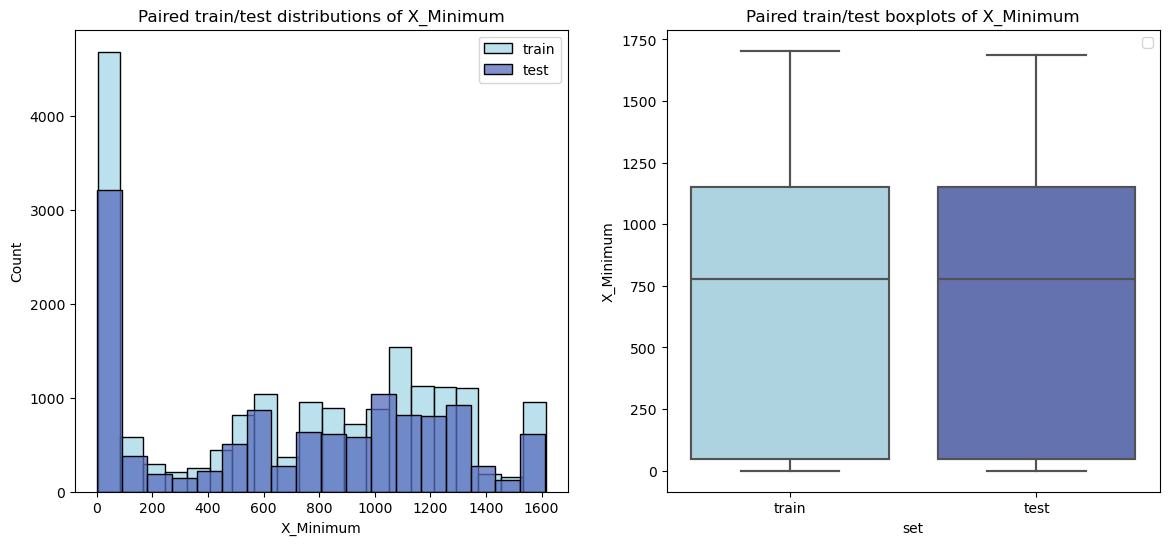

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


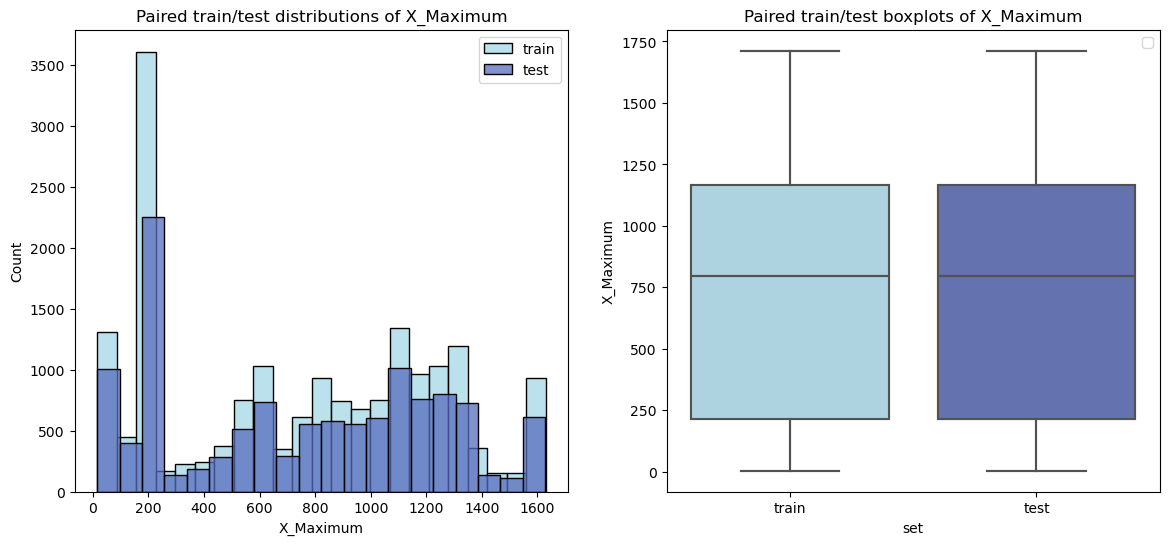

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


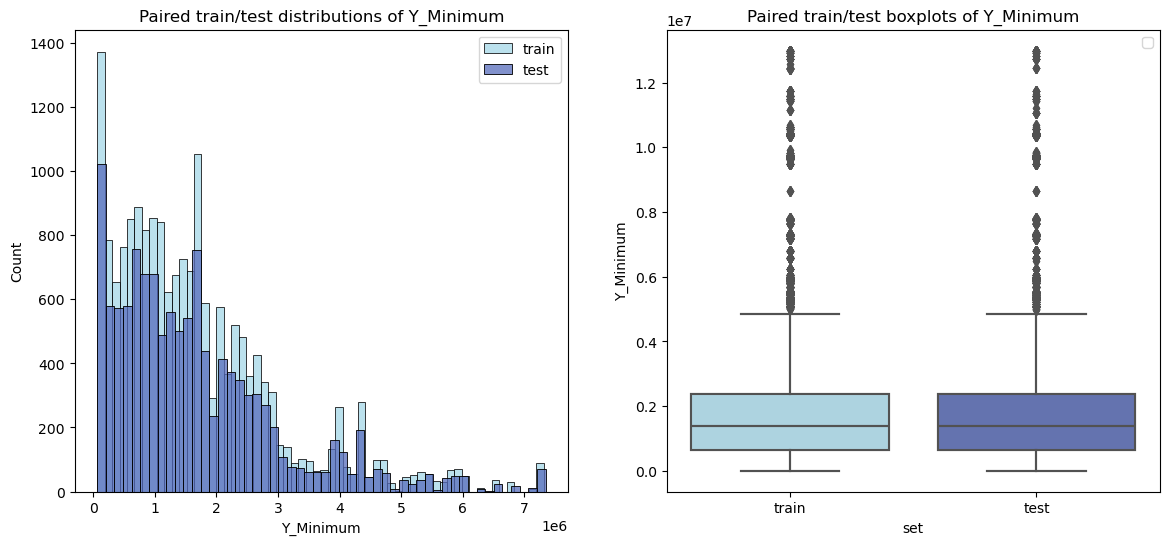

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


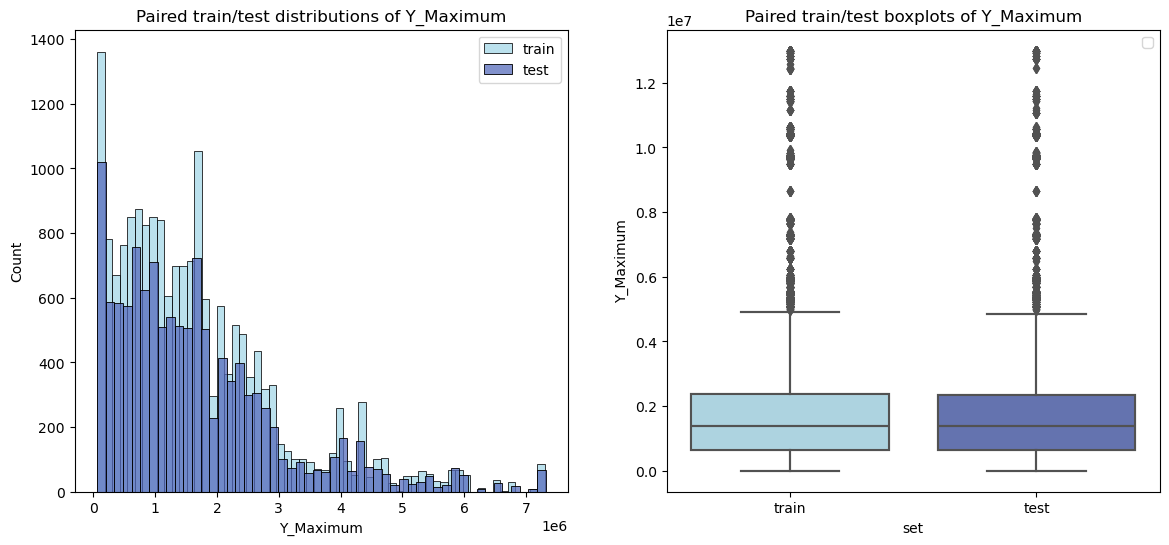

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


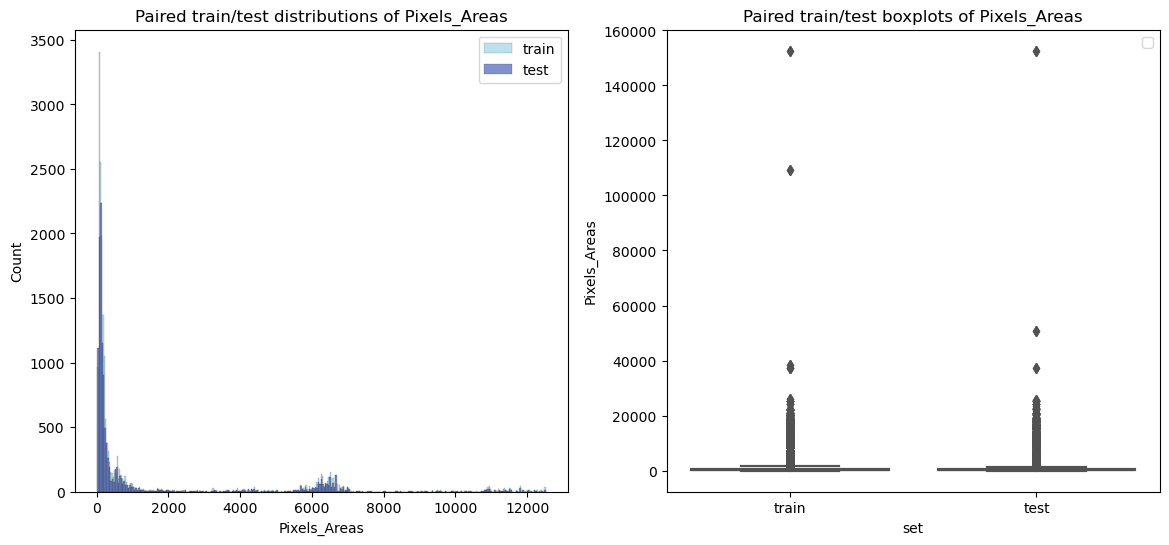

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


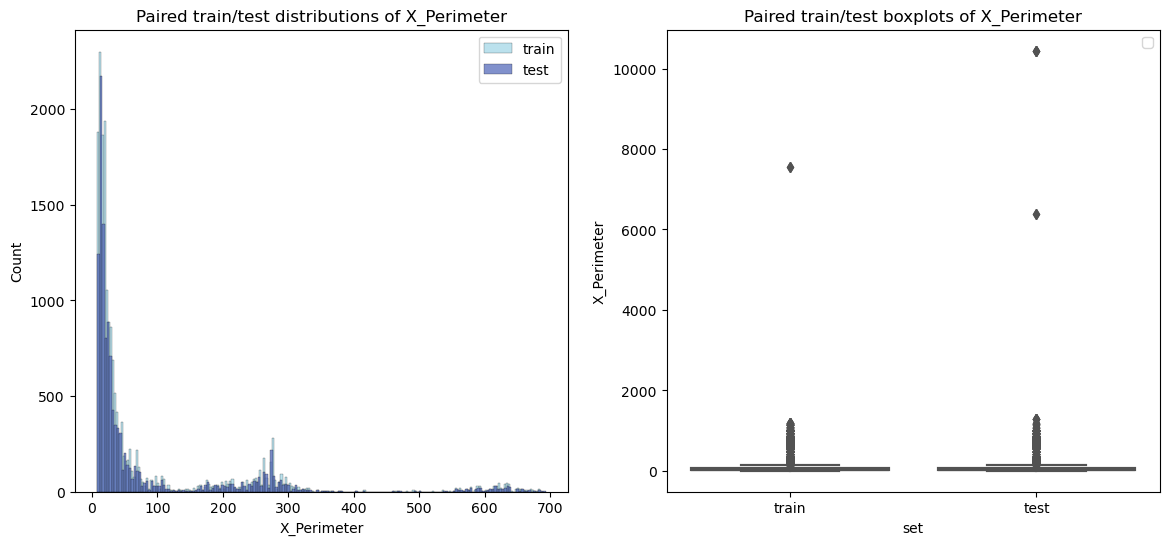

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


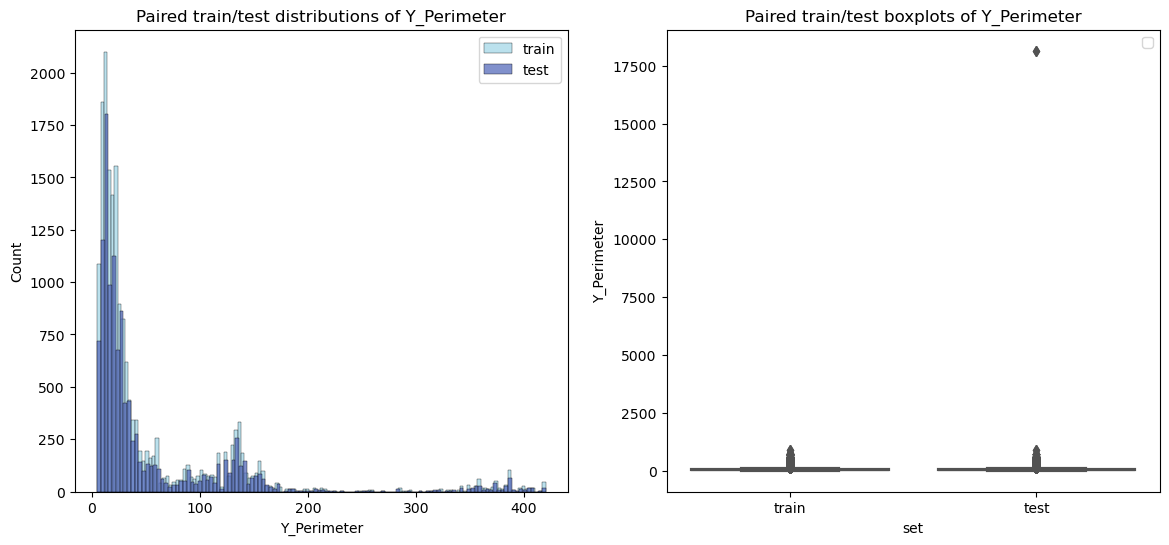

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


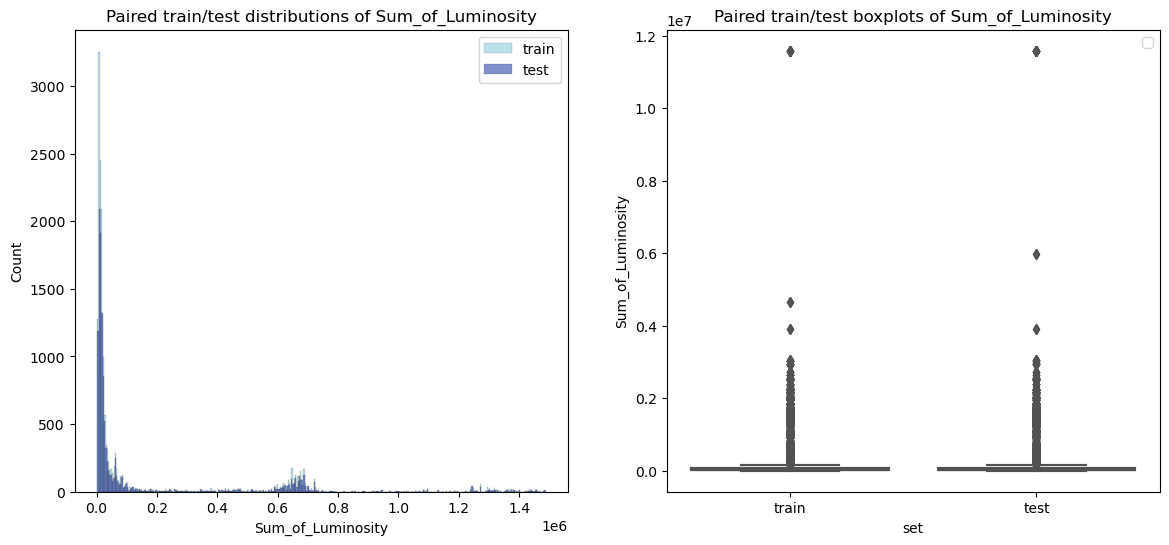

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


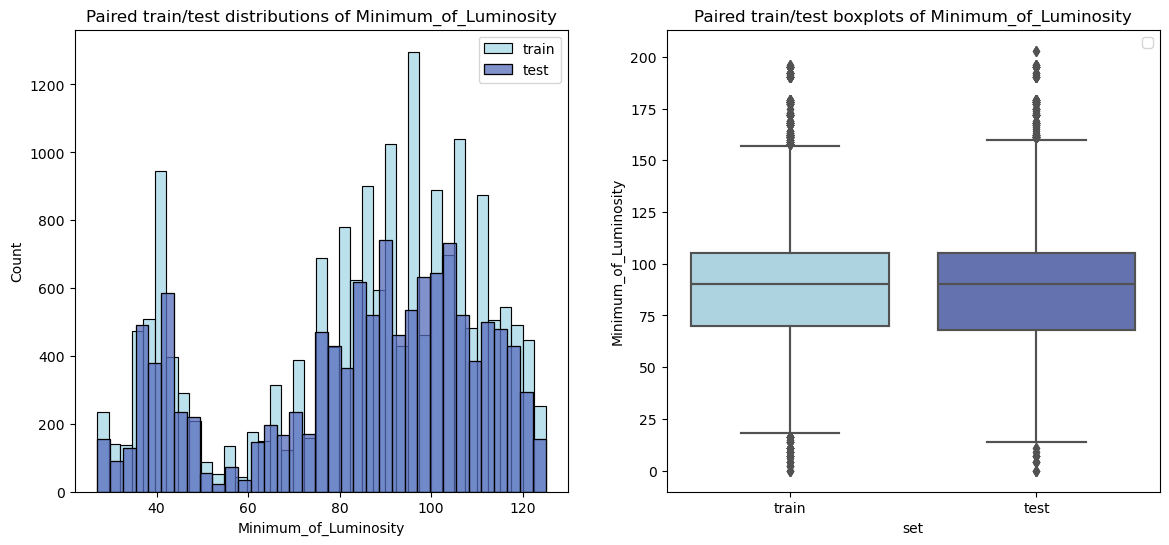

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


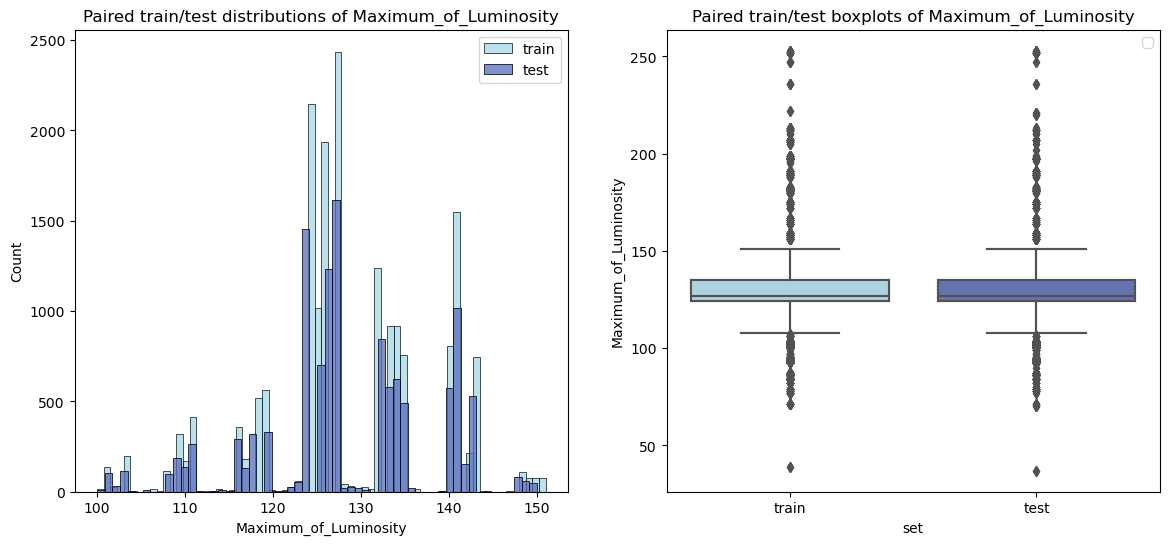

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


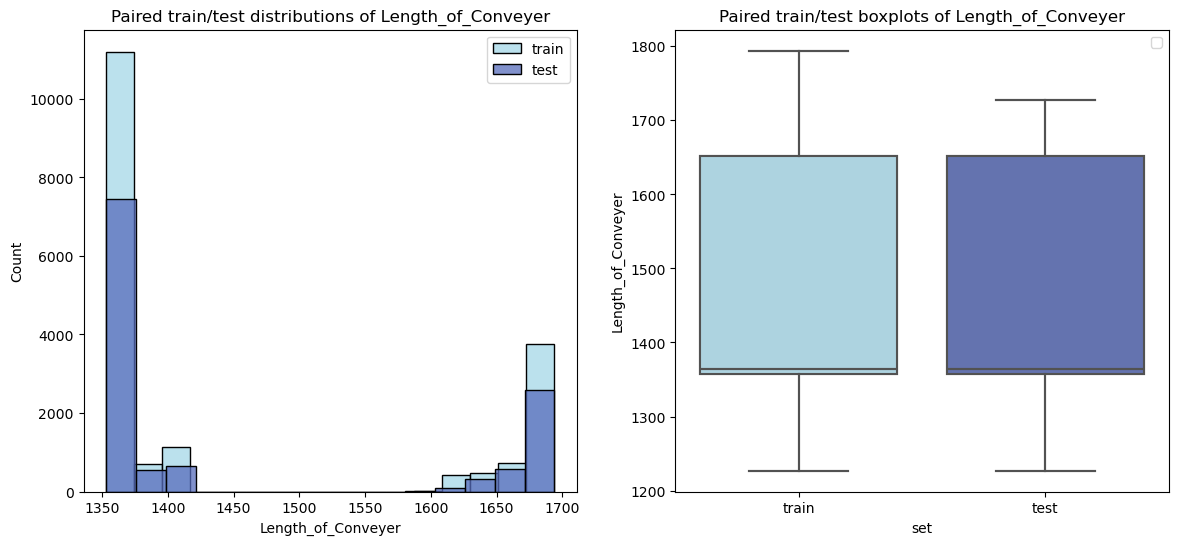

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


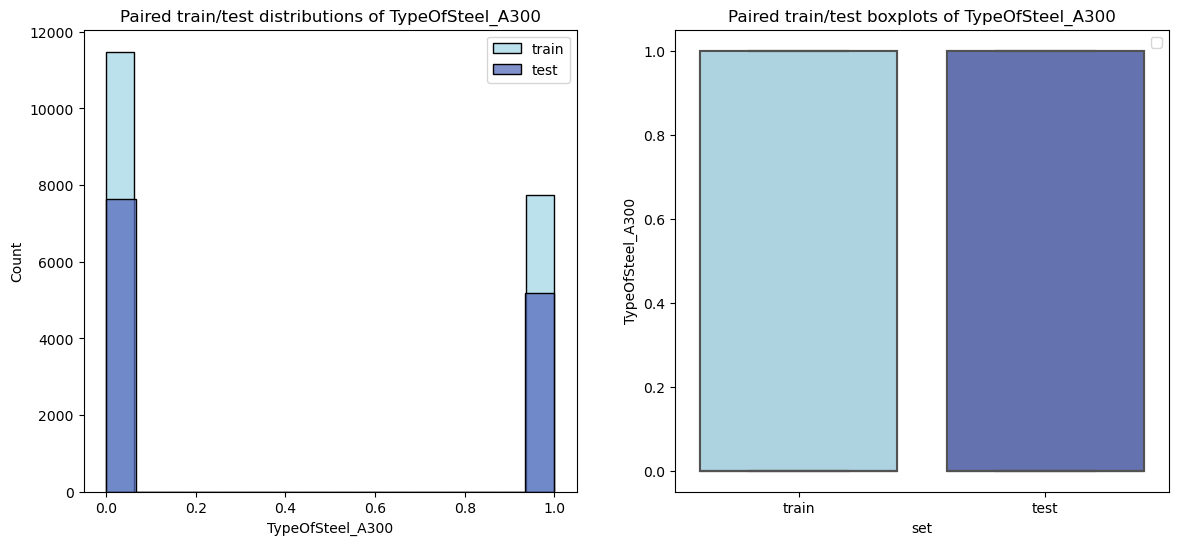

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


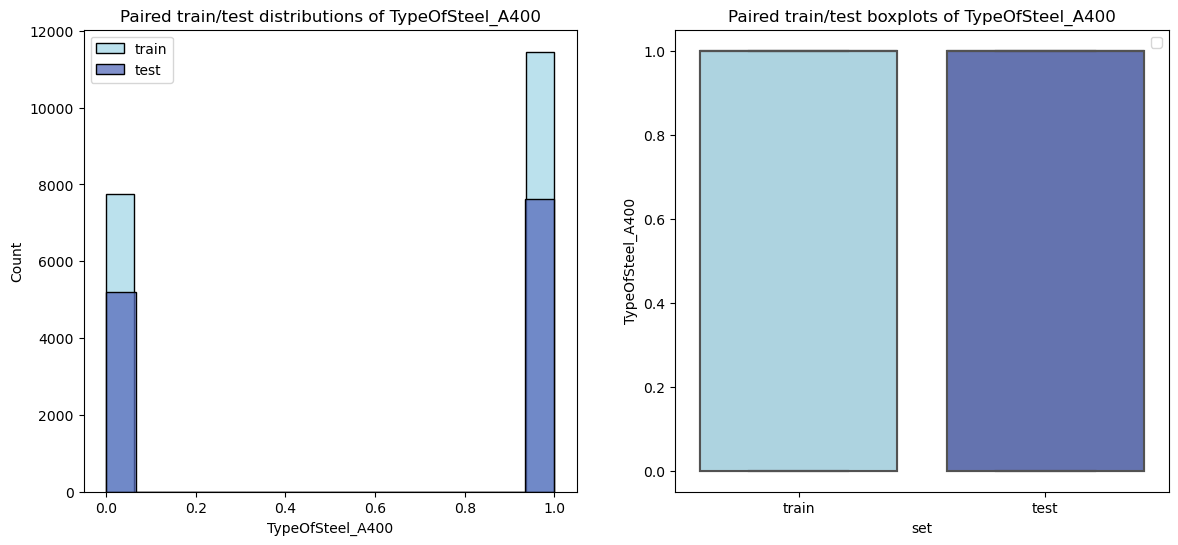

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


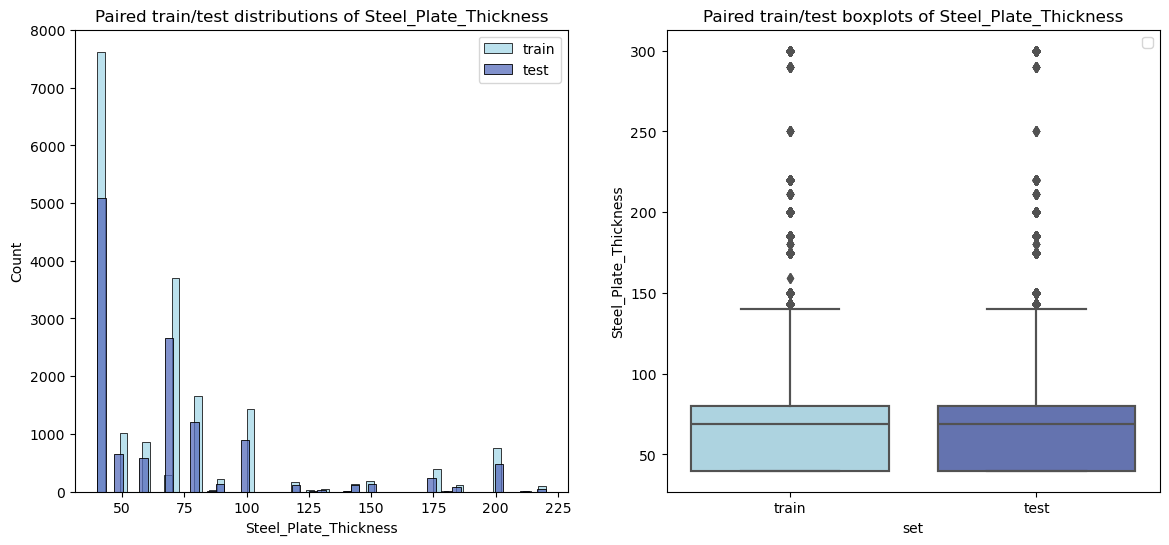

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


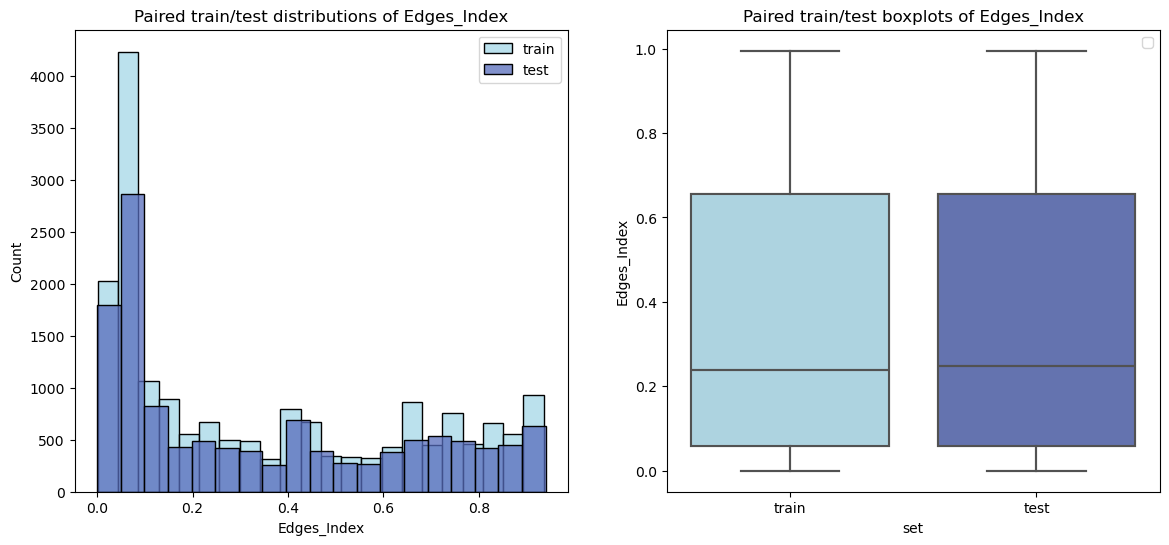

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


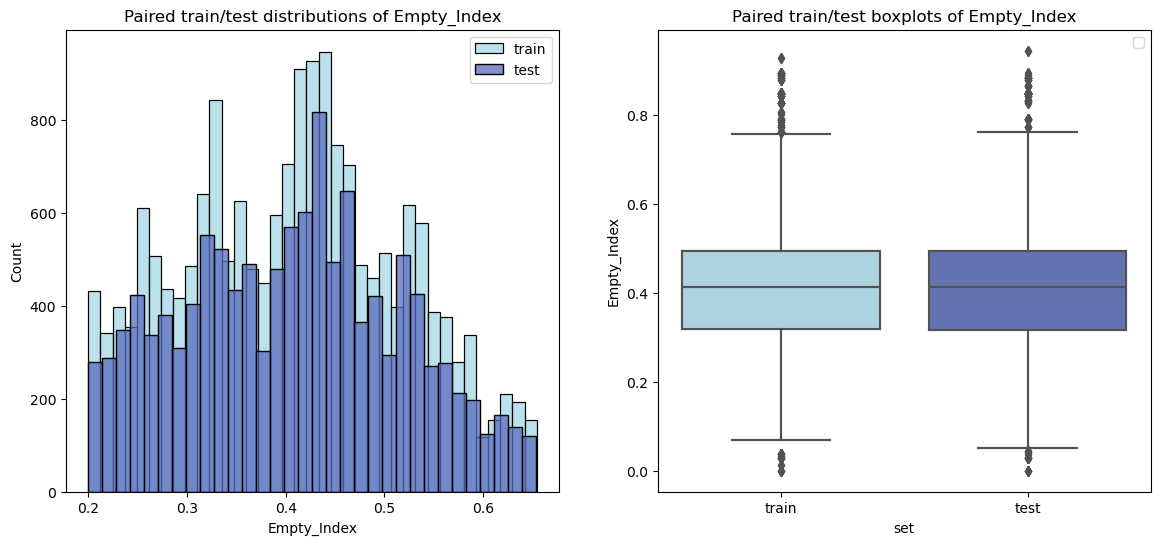

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


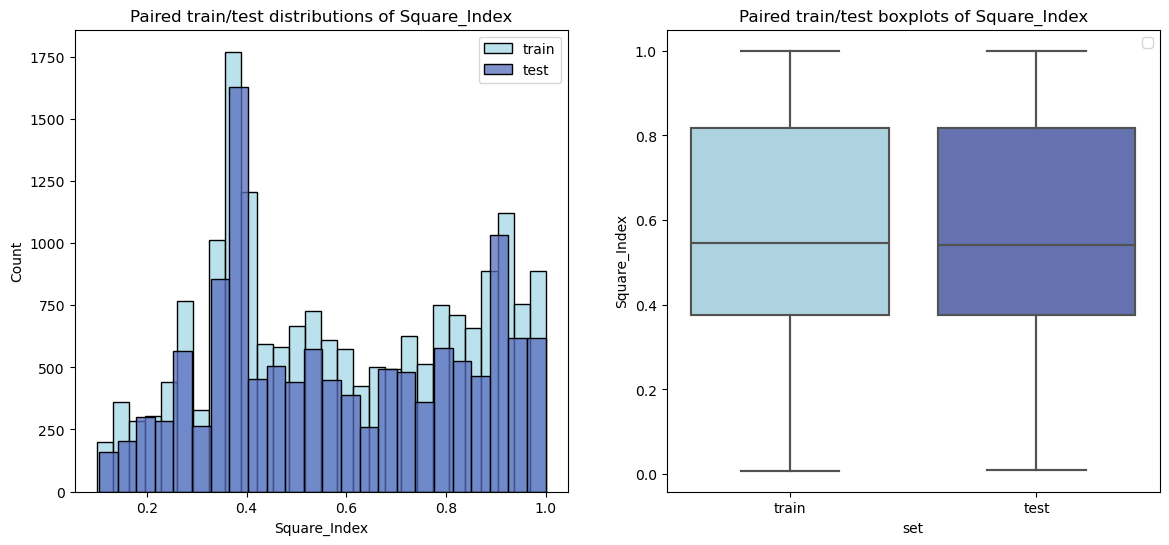

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


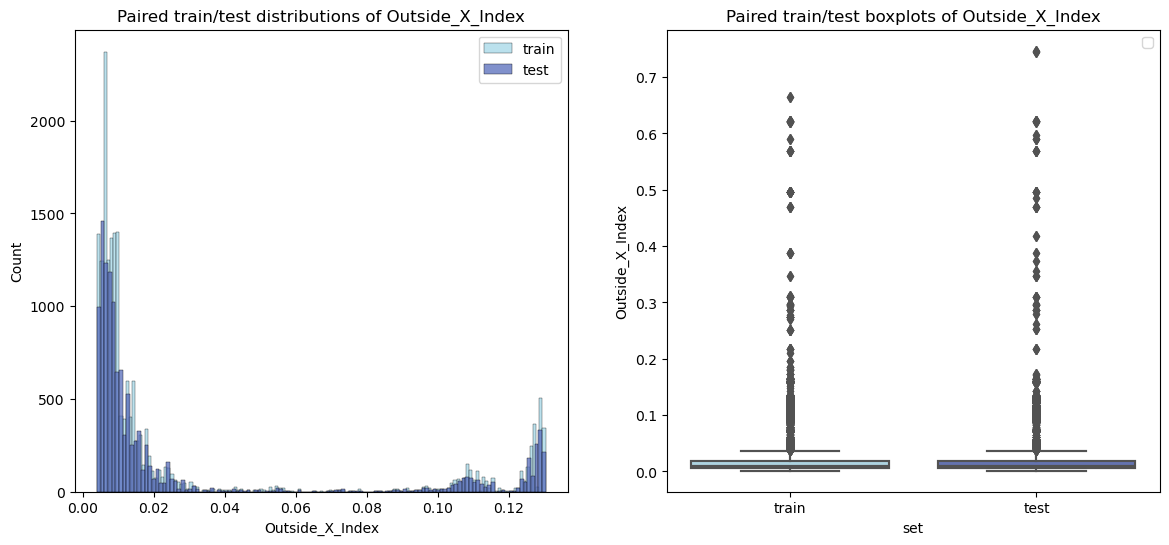

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


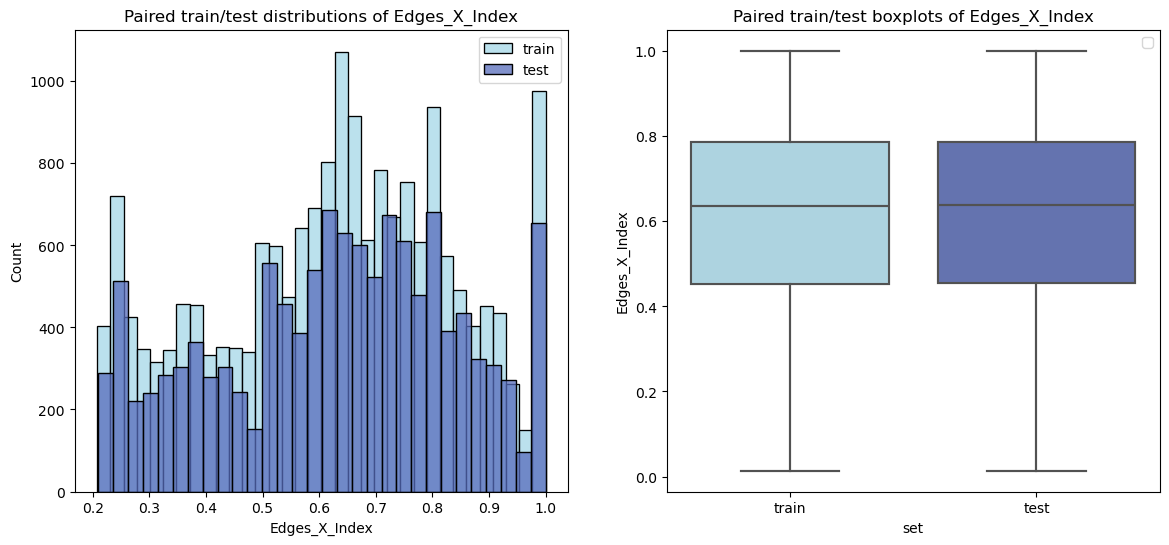

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


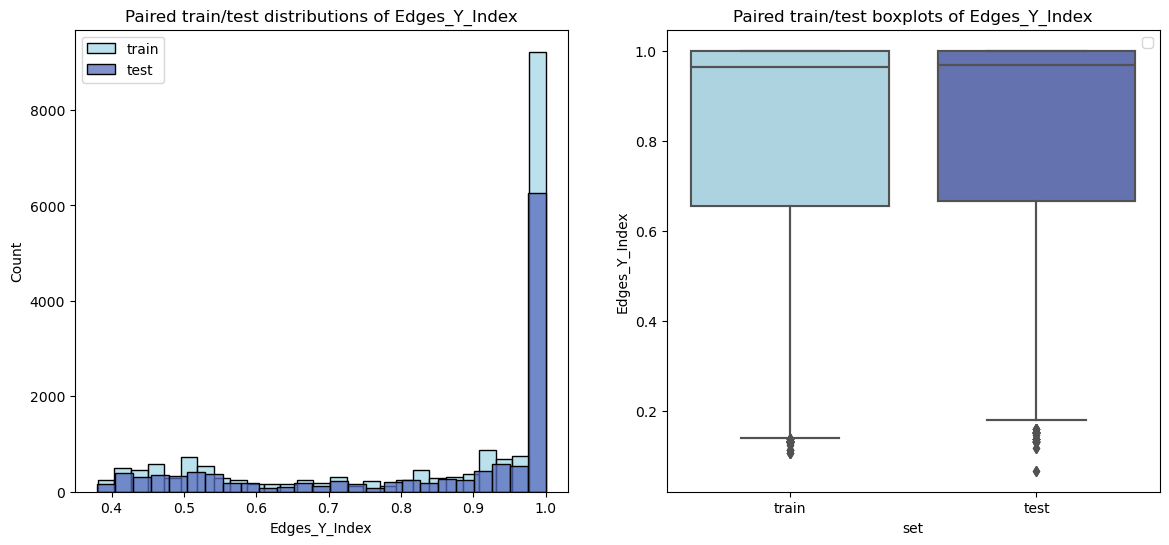

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


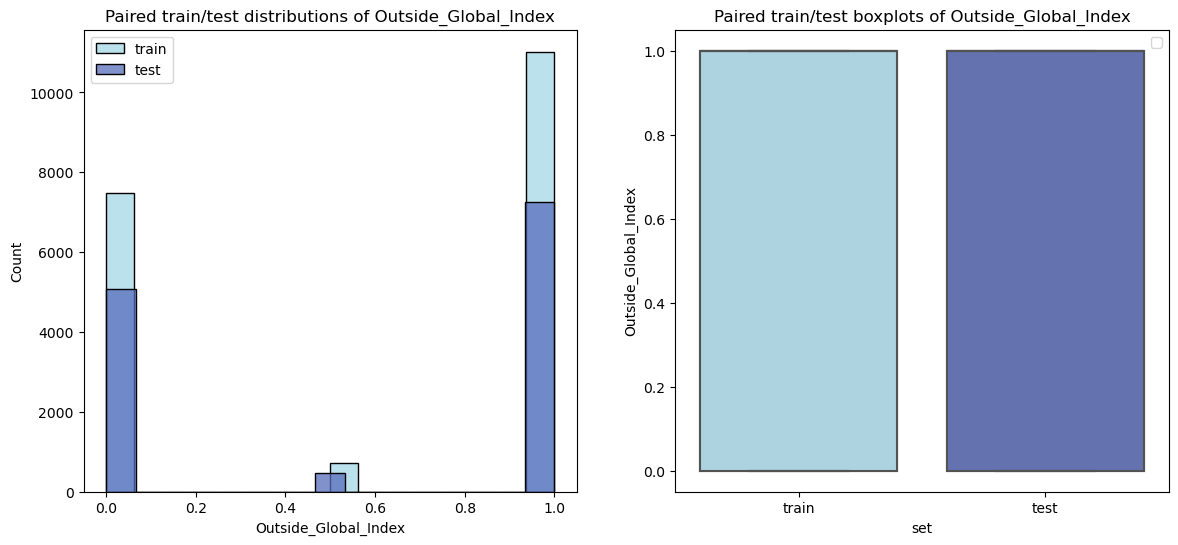

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


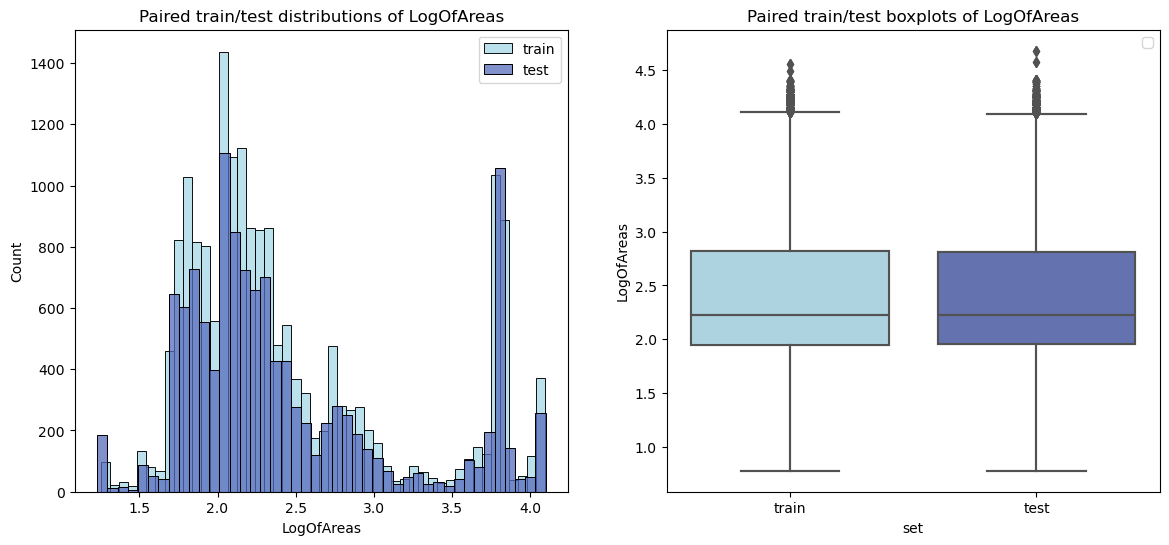

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


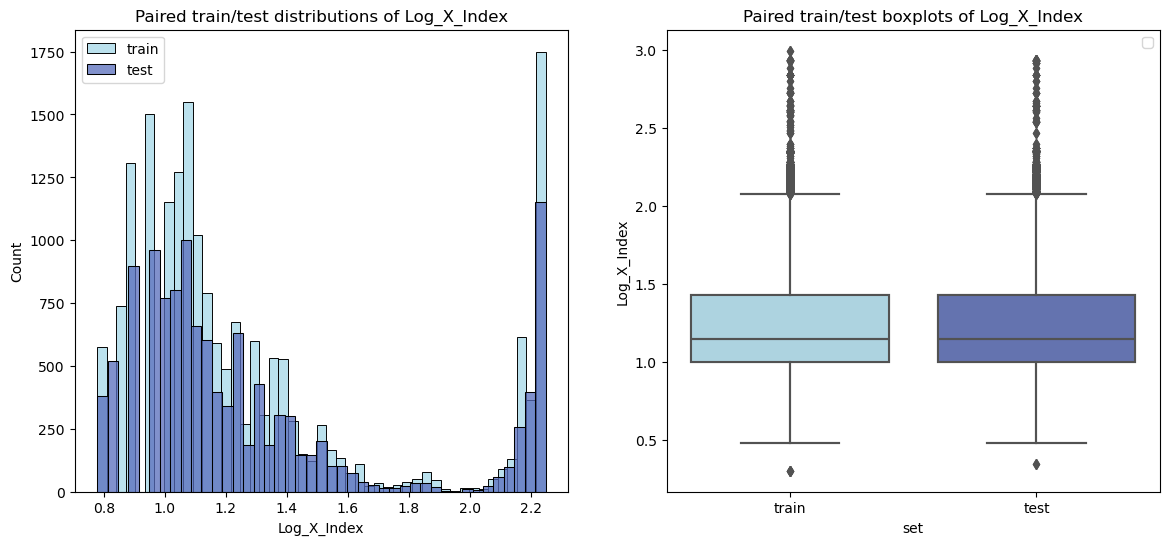

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


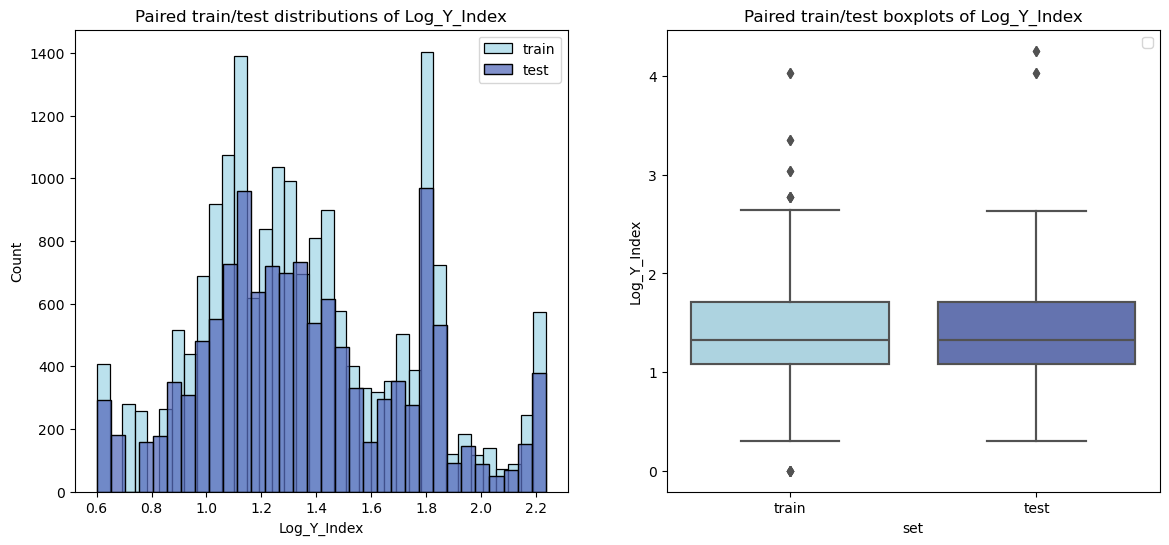

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


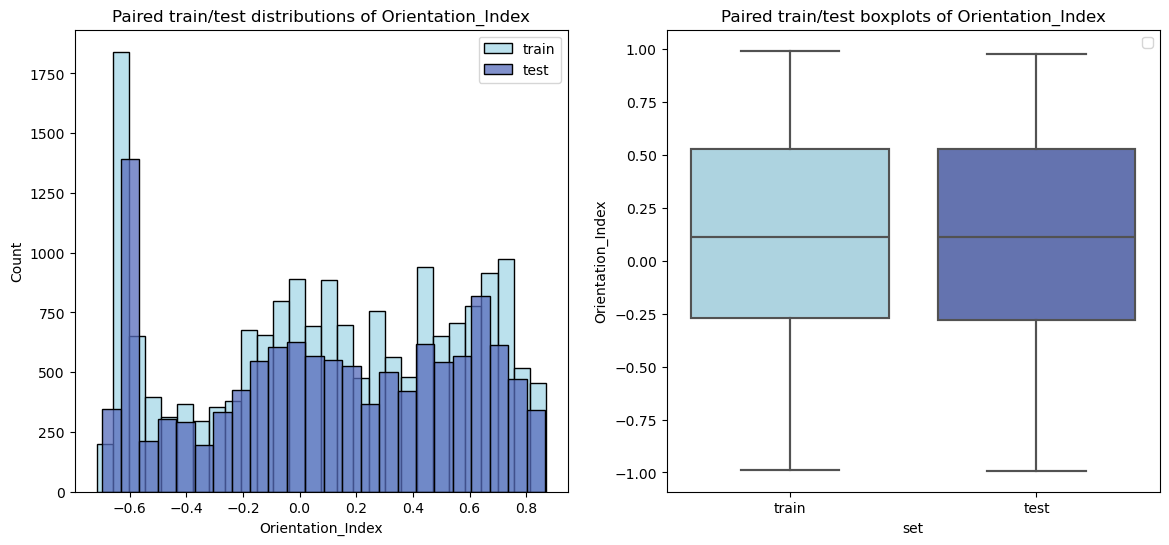

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


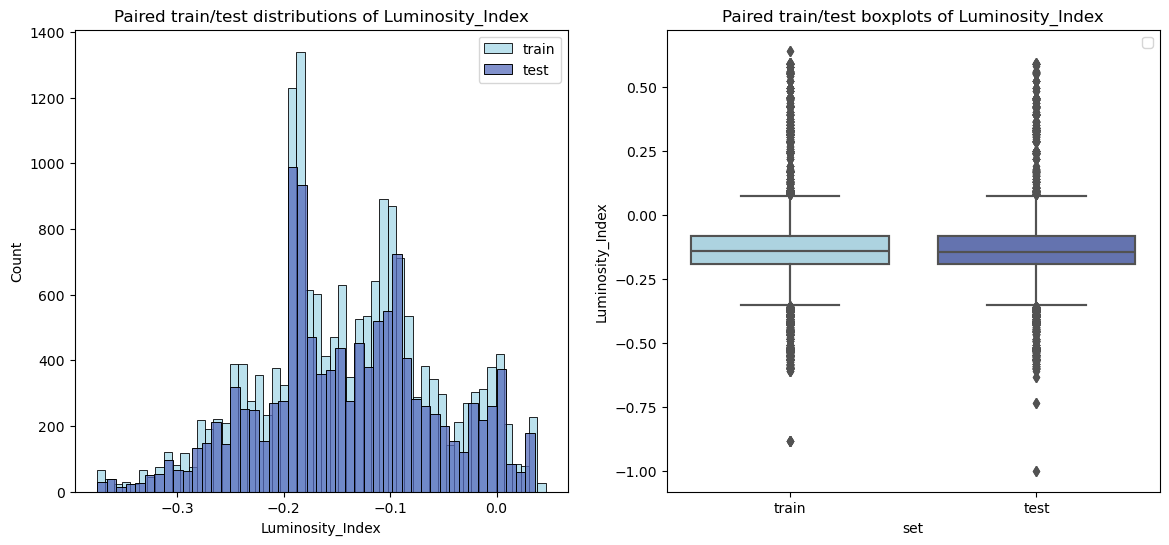

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


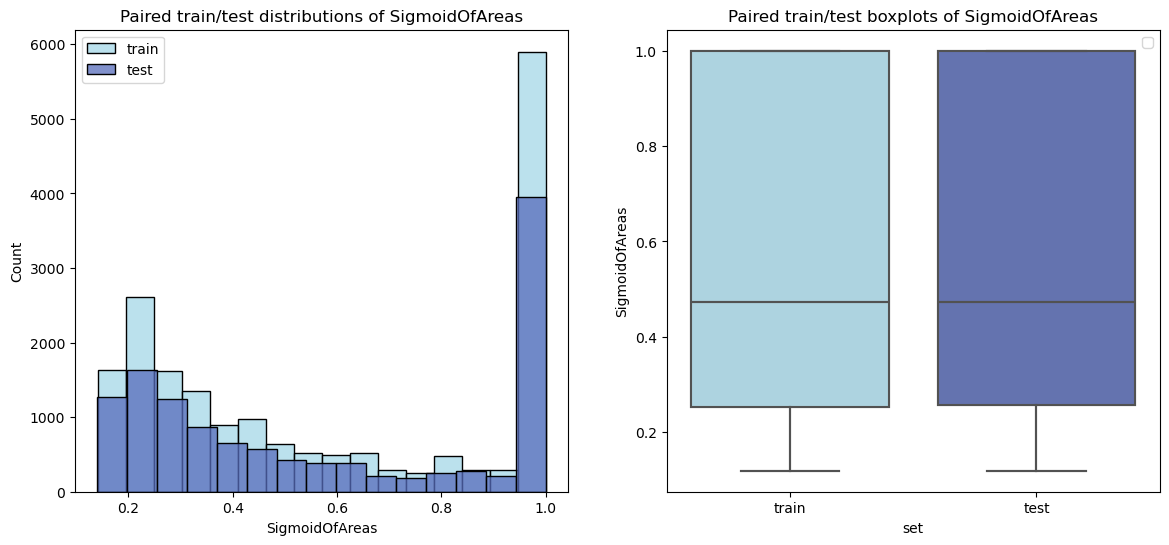

In [29]:
color_list = ["#A5D7E8", "#576CBC", "#19376D", "#0B2447"]
cmap_custom = ListedColormap(color_list)

def plot_distribution_pairs(train, test, feature, hue="set", palette=None):
    data_df = train.copy()
    data_df['set'] = 'train'
    data_df = pd.concat([data_df, test.copy()]).fillna('test')
    data_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    f, axes = plt.subplots(1, 2, figsize=(14, 6))
    for i, s in enumerate(data_df[hue].unique()):
        selection = data_df.loc[data_df[hue]==s, feature]
        # Filter 'selection' to include only the central 95% of the data
        q_025, q_975 = np.percentile(selection, [2.5, 97.5])
        selection_filtered = selection[(selection >= q_025) & (selection <= q_975)]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            sns.histplot(selection_filtered, color=palette[i], ax=axes[0], label=s)
            sns.boxplot(x=hue, y=feature, data=data_df, palette=palette, ax=axes[1])
    axes[0].set_title(f"Paired train/test distributions of {feature}")
    axes[1].set_title(f"Paired train/test boxplots of {feature}")
    axes[0].legend()
    axes[1].legend()
    plt.show()

    
for feature in train.columns:
    plot_distribution_pairs(train, test, feature, palette=color_list)

#### 3.4 - Feature engineering

In [49]:
train.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
id,,,,,,,,,,,,,,,,,,,,,
0,584,590,909972,909977,16,8,5,2274,113,140,...,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998


In [50]:
class Preprocess:

    def transform(self, X):
        X['X_Range'] = X['X_Maximum'] - X['X_Minimum']
        X['Y_Range'] = X['Y_Maximum'] - X['Y_Minimum']

        X['Density'] = X['Pixels_Areas'] / (X['X_Perimeter'] + X['Y_Perimeter'])

        X['Color_Contrast'] = X['Maximum_of_Luminosity'] - X['Minimum_of_Luminosity']
        X['Average_Luminosity'] = (X['Sum_of_Luminosity'] + X['Minimum_of_Luminosity']) / 2

        return X
    
train = Preprocess().transform(train)
test = Preprocess().transform(test)


### 4 - Modelling

For speeding up things, we are going to rescale the features in the range 0-1.

In [52]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

train = train.astype(np.float64)
test = test.astype(np.float64)

mmscaler = MinMaxScaler()

train = mmscaler.fit_transform(train)
test = mmscaler.transform(test)

In [62]:
def auc_score(y, y_pred):
    return roc_auc_score(y, y_pred, multi_class='ovr')

In [66]:
from sklearn.model_selection import StratifiedShuffleSplit
import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

def XGB(trial):
    model = XGBClassifier(
        device='cuda',
        max_depth=trial.suggest_int('max_depth', 1, 100),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        n_estimators=trial.suggest_int('n_estimators', 50, 1000),
        min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
        gamma=trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        subsample=trial.suggest_float('subsample', 0.01, 1.0, log=True),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
        reg_alpha=trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        reg_lambda=trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        objective='multi:softmax',
        random_state=27
    )
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    return auc_score(y_test, y_pred)


def LGBM(trial):
    model = LGBMClassifier(
        n_estimators=trial.suggest_int("n_estimators", 100, 1000),
        max_depth=trial.suggest_int("max_depth", 1, 100),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        objective='multiclass',
        metric= "multi_logloss",
        verbosity=-1,
        num_class = len(targets),
        boosting_type=trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        num_leaves=trial.suggest_int('num_leaves', 2, 256),
        min_child_samples=trial.suggest_int('min_child_samples', 5, 100),
        random_state=27
    )

    cv_scores = []
    for i, (train_index, test_index) in enumerate(splitter.split(train, y)):
        X_train, X_test = train[train_index], train[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)
        cv_scores.append(auc_score(y_test, y_pred))

    return np.mean(cv_scores)

splitter = StratifiedShuffleSplit(n_splits=5, random_state=42)
y = np.argmax(targets_bin, axis=1)

sampler = optuna.samplers.TPESampler(seed=27, multivariate=True)
study = optuna.create_study(study_name="LGBM",direction='maximize', sampler=sampler)
study.optimize(LGBM, n_trials=50, show_progress_bar=False)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
print()

[I 2024-03-11 10:22:56,293] A new study created in memory with name: LGBM
[I 2024-03-11 10:23:55,402] Trial 0 finished with value: 0.8630894614283205 and parameters: {'n_estimators': 483, 'max_depth': 82, 'learning_rate': 0.02956613668999794, 'boosting_type': 'gbdt', 'num_leaves': 251, 'min_child_samples': 90}. Best is trial 0 with value: 0.8630894614283205.
[I 2024-03-11 10:24:28,009] Trial 1 finished with value: 0.8671539530748136 and parameters: {'n_estimators': 288, 'max_depth': 75, 'learning_rate': 0.02119759734120936, 'boosting_type': 'gbdt', 'num_leaves': 193, 'min_child_samples': 88}. Best is trial 1 with value: 0.8671539530748136.
[I 2024-03-11 10:24:39,609] Trial 2 finished with value: 0.8683229301181422 and parameters: {'n_estimators': 268, 'max_depth': 33, 'learning_rate': 0.00557025234204438, 'boosting_type': 'gbdt', 'num_leaves': 45, 'min_child_samples': 12}. Best is trial 2 with value: 0.8683229301181422.
[I 2024-03-11 10:25:33,814] Trial 3 finished with value: 0.8597957

Number of finished trials:  50
Best trial:
  Value:  0.8742821733359515
  Params: 
    n_estimators: 775
    max_depth: 36
    learning_rate: 0.03816776022965723
    boosting_type: dart
    num_leaves: 7
    min_child_samples: 100

